# Поиск штрихкодов

## Загрузка датасета

In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from pathlib import Path
import csv
import cv2
import numpy as np
from torch.utils.data import random_split

In [2]:
DATASET_PATH = Path('D:/CourseOCRTask3/Train/markup.csv')
TRAIN_PATH = Path('D:/CourseOCRTask3/Train/Images')

In [3]:
data = []
with open(DATASET_PATH, 'r', encoding='utf-16') as file:
    reader = csv.reader(file)
    for row in reader:
        path_to_img = TRAIN_PATH.joinpath(row[0])
        row[0] = path_to_img
        if path_to_img.exists():
            data.append(row)

In [4]:
len(data)

3828

In [5]:
def convert_to_rgb(path):
    images = []
    img = cv2.imread(str(path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img_rgb)

    return images

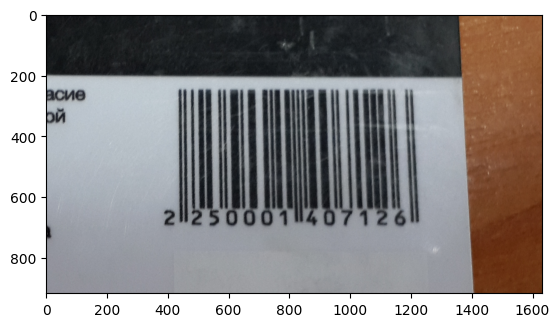

In [6]:
images = convert_to_rgb(data[0][0])
plt.imshow(images[0])
plt.show()

In [7]:
def convert_targets_to_mask(image_shape, corner_coordinates):
    mask = np.zeros(image_shape)
    cv2.fillConvexPoly(mask, np.array(corner_coordinates), 1)
    return mask

In [8]:
import torch
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader

class BarcodeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dt = self.data[idx]

        try:
            img = np.array(convert_to_rgb(dt[0])[0])
        except:
            idx = 0
            return self.__getitem__(idx)

        img = transforms.ToTensor()(img)

        corner_coordinates = [[int(dt[2]), int(dt[3])], [int(dt[4]), int(dt[5])], [int(dt[6]), int(dt[7])], [int(dt[8]), int(dt[9])]]
        mask = torch.FloatTensor(convert_targets_to_mask(img.size()[1:], corner_coordinates)).unsqueeze(0)

        mask = transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST)(mask).to(device)
        img = transforms.Resize((256, 256))(img).to(device)

        return img, mask

In [9]:
train_dataset, val_dataset = random_split(BarcodeDataset(data), lengths=[0.8, 0.2])

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Train dataset size: 3063
Validation dataset size: 765


In [10]:
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

## Архитектура модели

Для поиска штрихкода воспользуемся нейросетевыми методами, а точнее $-$ нейросетью для семантической сегментации изображения. Остановимся на архитектуре UNet, которая хорошо себя зарекомендовала в решении задач, связанными с обработкой медицинских изображений.

In [11]:
from torchvision.transforms import CenterCrop

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1)
        )
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1)
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1)
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1)
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        b_upsampled = self.upsample0(b)
        d0 = self.dec_conv0(torch.concat((b_upsampled, CenterCrop(b_upsampled.shape[2:4])(e3)), dim=1))
        d0_upsampled = self.upsample1(d0)
        d1 = self.dec_conv1(torch.concat((d0_upsampled, CenterCrop(d0_upsampled.shape[2:4])(e2)), dim=1))
        d1_upsampled = self.upsample2(d1)
        d2 = self.dec_conv2(torch.concat((d1_upsampled, CenterCrop(d1_upsampled.shape[2:4])(e1)), dim=1))
        d2_upsampled = self.upsample3(d2)
        d3 = self.dec_conv3(torch.concat((d2_upsampled, CenterCrop(d2_upsampled.shape[2:4])(e0)), dim=1))
        return d3

In [12]:
!pip install pytorch_lightning

In [13]:
!pip install lightning

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [13]:
import sys
sys.path.append('C:/Users/Vlad/A4-OCR-Intro/task3')

In [14]:
from utils.metrics import CombinedLoss
from lightning.pytorch.loggers import TensorBoardLogger
import lightning

In [15]:
class Model(lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet()
        self.criterion = CombinedLoss()
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(params=self.model.parameters())
        return optimizer

In [17]:
model = Model().to(device)
logger = TensorBoardLogger("tb_logs", name="UNet")
trainer = lightning.Trainer(accelerator='gpu', logger=logger, max_epochs=1)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params
-------------------------------------------
0 | model     | UNet         | 25.1 M
1 | criterion | CombinedLoss | 0     
-------------------------------------------
25.1 M    Trainable params
0         Non-trainable params
25.1 M    Total params
100.342   Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

OSError: [Errno 28] No space left on device

## Измерим качество модели

In [19]:
class BarcodeTestDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = self.data[idx]
        img = np.array(convert_to_rgb(path)[0])
        img = transforms.ToTensor()(img)
        img_size = img.size()[1:]
        img = transforms.Resize((256, 256))(img)

        return img, img_size, path

In [21]:
TEST_PATH = Path('D:/CourseOCRTask3/Test/Images')
image_list = list(TEST_PATH.glob('*'))
test_dataset = BarcodeTestDataset(image_list)

In [22]:
def find_corners(mask):
    binary_mask = (torch.sigmoid(mask) > 0.5).cpu().numpy().astype(np.uint8)

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)

    x, y = contour[:, 0, 0], contour[:, 0, 1]

    corners_indices = np.array([np.argmin(x + y), np.argmin(-x + y), np.argmax(x + y), np.argmax(-x + y)])
    corners = np.array([x[corners_indices], y[corners_indices]]).T

    return corners.astype(float)

In [27]:
from tqdm import tqdm

In [29]:
corners = []
image_name = []

model.eval()
with torch.no_grad():
    for i in tqdm(range(len(test_dataset))):
        img, sz, path = test_dataset[i]
        try:
            mask = model.model(img.unsqueeze(0))
        except:
            continue
        mask = transforms.Resize((sz[0], sz[1]), interpolation=InterpolationMode.NEAREST)(mask)

        corners.append(find_corners(mask.squeeze()))
        image_name.append(str(path).split('/')[-1])


 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [00:26<00:04,  3.21it/s]


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [30]:
with open('answer.csv', mode='w', newline='', encoding='utf-16') as file:
    for i in range(len(corners)):
        file.write(image_name[i] + ',-,' + ','.join([str(int(j)) for j in np.resize(corners[i], 8)]) + ',-\n')

In [32]:
!pip install shapely

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 330.3 kB/s eta 0:00:05
   - -------------------------------------- 0.1/1.4 MB 550.5 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.4 MB 950.9 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.4 MB 1.5 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.4 MB 1.8 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.4 MB 2.3 MB/s eta 0:00:01
   ----------------------- ---------------- 0.8/1.4 MB 2.5 MB/s eta 0:00:01
   ----------------------- ---------------- 0.9/1.4 MB 2.3 MB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.4 MB 2.3 MB/s eta 0:00:01
   ----------------------------- ---------- 1.1/1.4 MB 2.3 MB/s eta 0:00:01
   ----------------------------------- ---- 1.3/1.4 MB 2.4 MB/s eta 0:00:01
   -----------------

In [33]:
from course_intro_ocr_t3.evaluate import main
sys.path.append('C:/Users/Vlad/A4-OCR-Intro/task3/course_intro_ocr_t3')

main()

Checking answer (C:\Users\Vlad\A4-OCR-Intro\task3\answer.csv) against markup(C:\Users\Vlad\A4-OCR-Intro\task3\markup.csv)
recognition_accuracy=0.98
detection_result=1.0
score=1.0
